In [5]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: suyee-tan21 (suyee-tan21-nus). Use `wandb login --relogin` to force relogin


True

In [7]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [8]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [9]:
# project name should correspond to dataset below
# project_name = "covertype"
project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"

In [10]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
else:
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()

Normal class:  0    smurf.
Name: attack, dtype: object
TARGET_DICT {0: 'apache2', 1: 'back', 2: 'buffer_overflow', 3: 'ftp_write', 4: 'guess_passwd', 5: 'httptunnel', 6: 'imap', 7: 'ipsweep', 8: 'land', 9: 'loadmodule', 10: 'mailbomb', 11: 'mscan', 12: 'multihop', 13: 'named', 14: 'neptune', 15: 'nmap', 16: 'normal', 17: 'perl', 18: 'phf', 19: 'pod', 20: 'portsweep', 21: 'processtable', 22: 'ps', 23: 'rootkit', 24: 'saint', 25: 'satan', 26: 'sendmail', 27: 'smurf', 28: 'snmpgetattack', 29: 'snmpguess', 30: 'sqlattack', 31: 'teardrop', 32: 'udpstorm', 33: 'warezmaster', 34: 'worm', 35: 'xlock', 36: 'xsnoop', 37: 'xterm'}
NORMAL_TARGET 16
main_labels ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate'

In [11]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
all_df.shape

(311029, 118)

In [13]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [14]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [15]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(248823, 117) (62206, 117) (248823,) (62206,)


In [16]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack
147391,0,226,3861,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16
107622,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
53448,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27
3099,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27
208489,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27


In [17]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [18]:
X_test_scaled_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
220755,-0.045752,-0.005491,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
158047,-0.045752,-0.012740,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25478,-0.045752,-0.005491,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99780,-0.045752,-0.012445,-0.043135,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
71382,-0.045752,-0.005491,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {27: 164091, 16: 60593, 14: 58001, 28: 7741, 10: 5000, 4: 4367, 29: 2406, 25: 1633, 33: 1602, 1: 1098, 11: 1053, 0: 794, 21: 759, 24: 736, 20: 354, 7: 306, 5: 158, 19: 87, 15: 84, 2: 22, 12: 18, 13: 17, 26: 17, 22: 16, 23: 13, 37: 13, 31: 12, 35: 9, 8: 9, 36: 4, 3: 3, 9: 2, 17: 2, 32: 2, 34: 2, 18: 2, 30: 2, 6: 1}
apache2.csv created with 2382 rows. (1588 benign and 794 abnormal rows)
back.csv created with 3294 rows. (2196 benign and 1098 abnormal rows)
buffer_overflow.csv created with 72 rows. (50 benign and 22 abnormal rows)
ftp_write.csv created with 53 rows. (50 benign and 3 abnormal rows)
guess_passwd.csv created with 13101 rows. (8734 benign and 4367 abnormal rows)
httptunnel.csv created with 474 rows. (316 benign and 158 abnormal rows)
imap.csv created with 51 rows. (50 benign and 1 abnormal rows)
ipsweep.csv created with 918 rows. (612 benign and 306 abnormal rows)
land.csv created with 59 rows. (50 benign and 9 abnormal rows)
loadmodule.csv created with 52 r

In [20]:
len(main_labels)

118

csv_files ['portsweep.csv', 'processtable.csv', 'phf.csv', 'loadmodule.csv', 'httptunnel.csv', 'mscan.csv', 'buffer_overflow.csv', 'sendmail.csv', 'imap.csv', 'back.csv', 'smurf.csv', 'ipsweep.csv', 'udpstorm.csv', 'ps.csv', 'neptune.csv', 'teardrop.csv', 'pod.csv', 'warezmaster.csv', 'named.csv', 'xterm.csv', 'snmpguess.csv', 'xsnoop.csv', 'rootkit.csv', 'ftp_write.csv', 'snmpgetattack.csv', 'saint.csv', 'sqlattack.csv', 'land.csv', 'perl.csv', 'apache2.csv', 'guess_passwd.csv', 'xlock.csv', 'nmap.csv', 'worm.csv', 'multihop.csv', 'satan.csv', 'mailbomb.csv']
Processing CSV file: portsweep.csv
portsweep importance list:
portsweep 
                     importance
Features                      
src_bytes                0.008
duration                 0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
su_attempted      

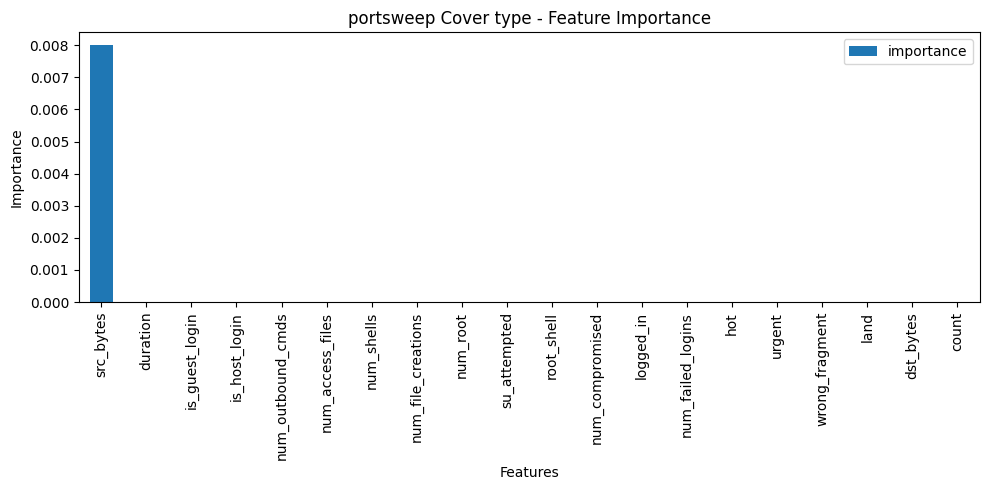

-----------------------------------------------------------------------------------------------




Processing CSV file: processtable.csv
processtable importance list:
processtable 
                     importance
Features                      
src_bytes             0.001478
dst_bytes             0.001401
logged_in             0.001281
duration              0.000000
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
root_shell            0.000000
su_attempted          0.000000
num_compromised       0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



processtable=["src_bytes","dst_bytes","logged_in","duration","num_root"]


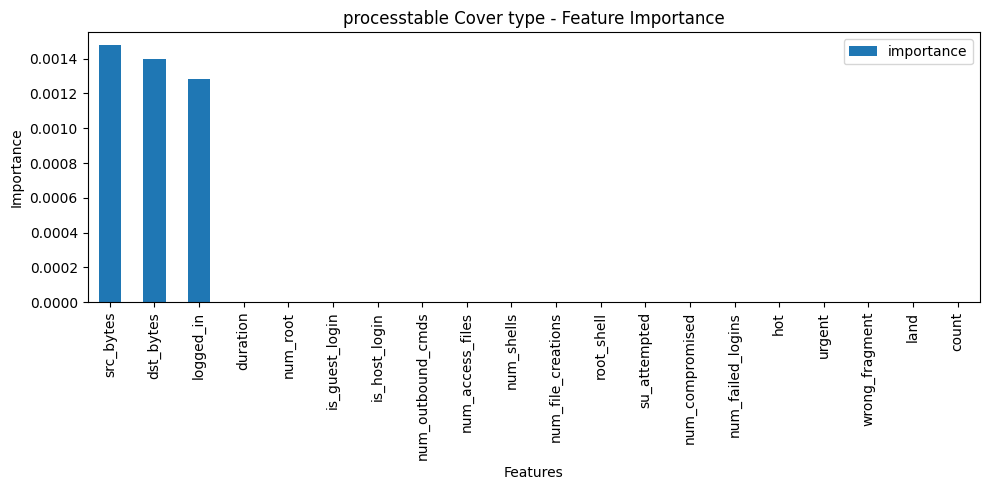

-----------------------------------------------------------------------------------------------




Processing CSV file: phf.csv
phf importance list:
phf 
                     importance
Features                      
hot                   0.136381
num_access_files      0.134578
src_bytes             0.126127
root_shell            0.124278
dst_bytes             0.016914
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_shells            0.000000
num_file_creations    0.000000
duration              0.000000
su_attempted          0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



phf=["hot","num_access_files","src_bytes","root_shell","dst_bytes"]


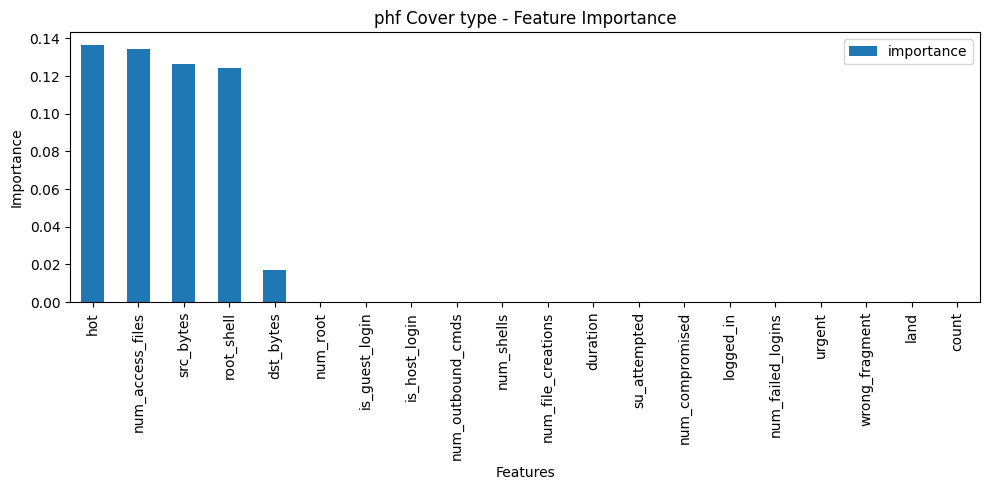

-----------------------------------------------------------------------------------------------




Processing CSV file: loadmodule.csv
loadmodule importance list:
loadmodule 
                     importance
Features                      
duration              0.165877
hot                   0.132701
num_compromised       0.127962
root_shell            0.109005
num_file_creations    0.090047
num_shells            0.075829
wrong_fragment        0.000000
urgent                0.000000
land                  0.000000
num_failed_logins     0.000000
logged_in             0.000000
dst_bytes             0.000000
src_bytes             0.000000
su_attempted          0.000000
num_root              0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



loadmodule=["duration","hot","num_compromised","root_shell","num_file_creations"]


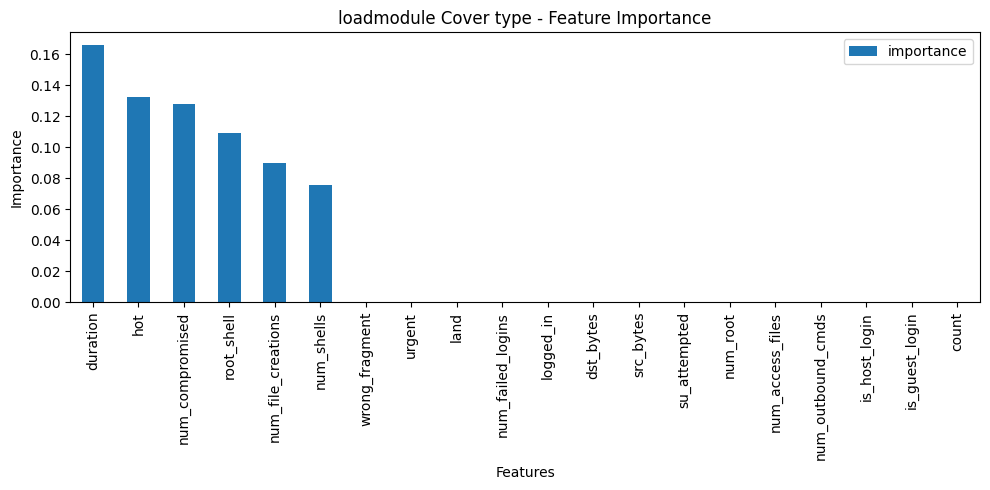

-----------------------------------------------------------------------------------------------




Processing CSV file: httptunnel.csv
httptunnel importance list:
httptunnel 
                     importance
Features                      
hot                   0.013714
src_bytes             0.002206
duration              0.001201
num_shells            0.000644
num_root              0.000601
num_compromised       0.000446
su_attempted          0.000297
count                 0.000233
root_shell            0.000197
dst_bytes             0.000123
logged_in             0.000029
num_failed_logins     0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
num_file_creations    0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



httptunnel=["hot","src_bytes","duration","num_shells","num_root"]


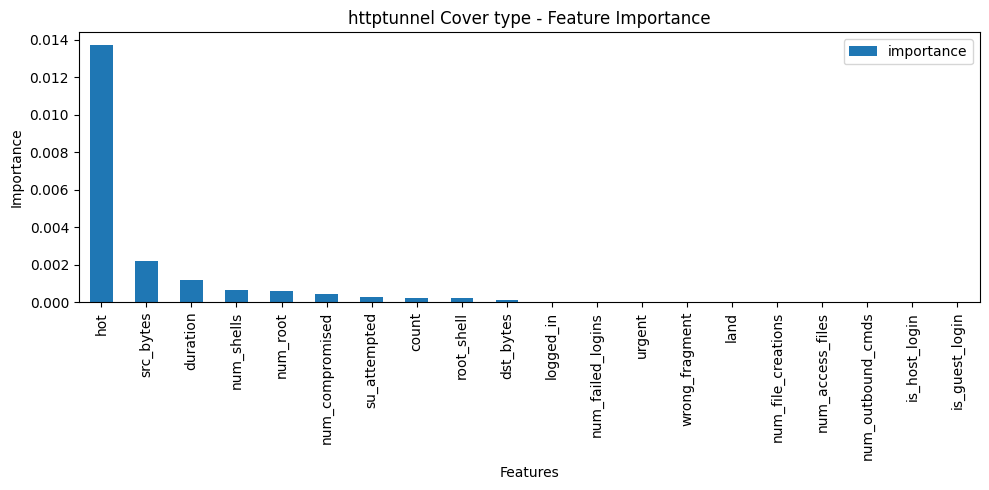

-----------------------------------------------------------------------------------------------




Processing CSV file: mscan.csv
mscan importance list:
mscan 
                     importance
Features                      
src_bytes             0.931919
count                 0.000023
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
root_shell            0.000000 



mscan=["src_bytes","count","is_guest_login","is_host_login","num_outbound_cmds"]


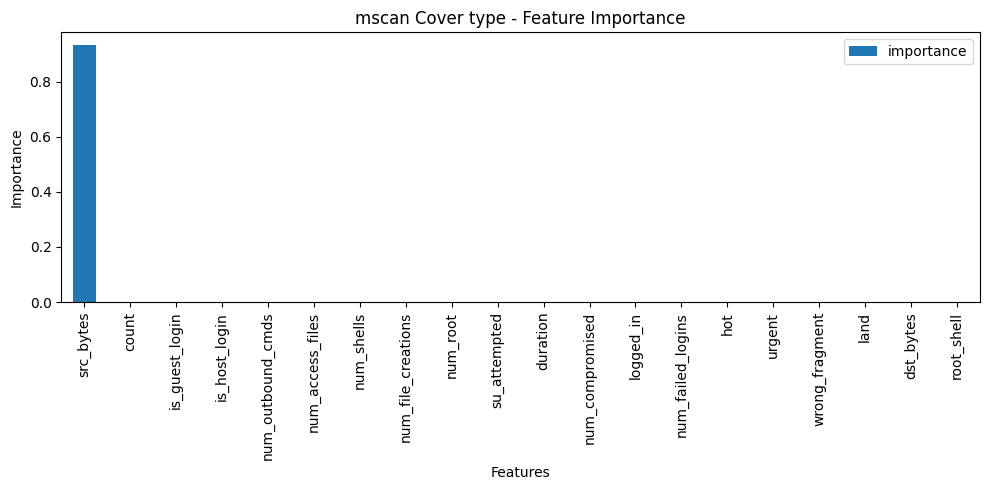

-----------------------------------------------------------------------------------------------




Processing CSV file: buffer_overflow.csv
buffer_overflow importance list:
buffer_overflow 
                     importance
Features                      
duration              0.159091
num_compromised       0.015119
src_bytes             0.013760
dst_bytes             0.008216
hot                   0.005778
count                 0.003053
root_shell            0.002495
num_file_creations    0.001244
num_access_files      0.001161
num_root              0.000369
urgent                0.000000
num_failed_logins     0.000000
logged_in             0.000000
wrong_fragment        0.000000
land                  0.000000
su_attempted          0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



buffer_overflow=["duration","num_compromised","src_bytes","dst_bytes","hot"]


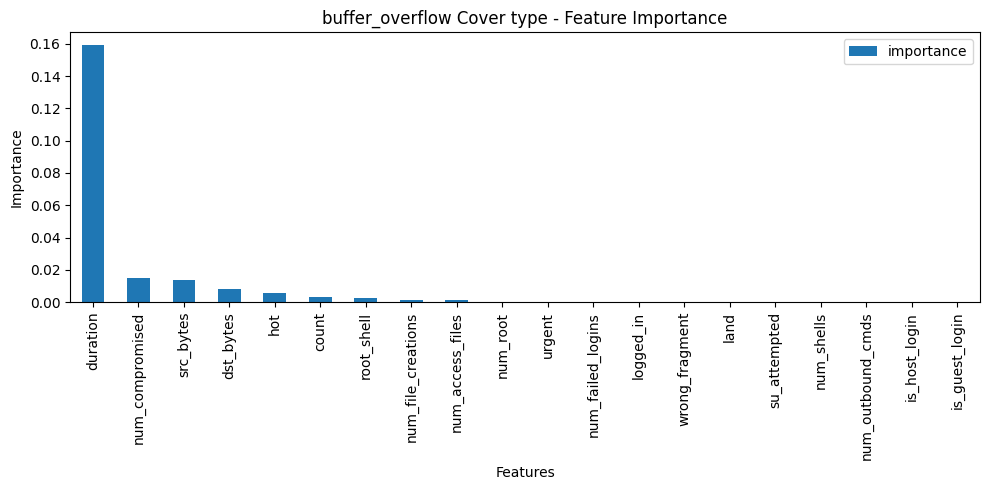

-----------------------------------------------------------------------------------------------




Processing CSV file: sendmail.csv
sendmail importance list:
sendmail 
                     importance
Features                      
duration              0.011862
num_access_files      0.011687
root_shell            0.010065
num_root              0.008916
src_bytes             0.006690
count                 0.000298
dst_bytes             0.000272
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_shells            0.000000
num_file_creations    0.000000
land                  0.000000
wrong_fragment        0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
su_attempted          0.000000 



sendmail=["duration","num_access_files","root_shell","num_root","src_bytes"]


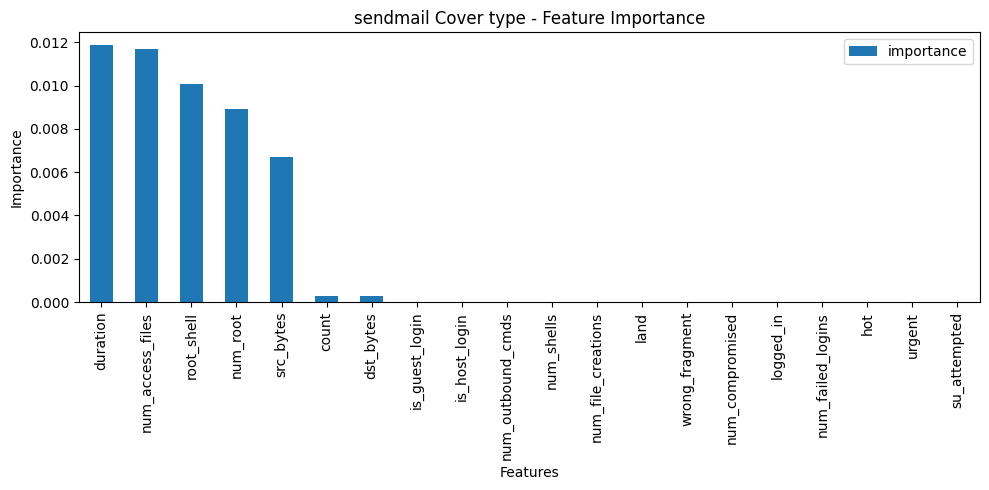

-----------------------------------------------------------------------------------------------




Processing CSV file: imap.csv
imap importance list:
imap 
                     importance
Features                      
duration              0.160256
src_bytes             0.044872
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



imap=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


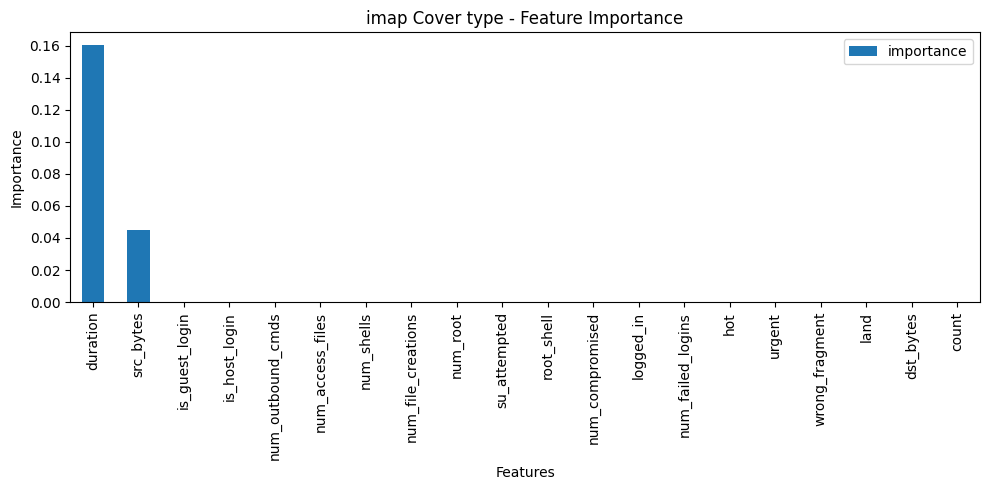

-----------------------------------------------------------------------------------------------




Processing CSV file: back.csv
back importance list:
back 
                     importance
Features                      
src_bytes             0.945254
hot                   0.047600
dst_bytes             0.004552
num_compromised       0.000192
duration              0.000011
count                 0.000009
urgent                0.000000
num_failed_logins     0.000000
logged_in             0.000000
wrong_fragment        0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



back=["src_bytes","hot","dst_bytes","num_compromised","duration"]


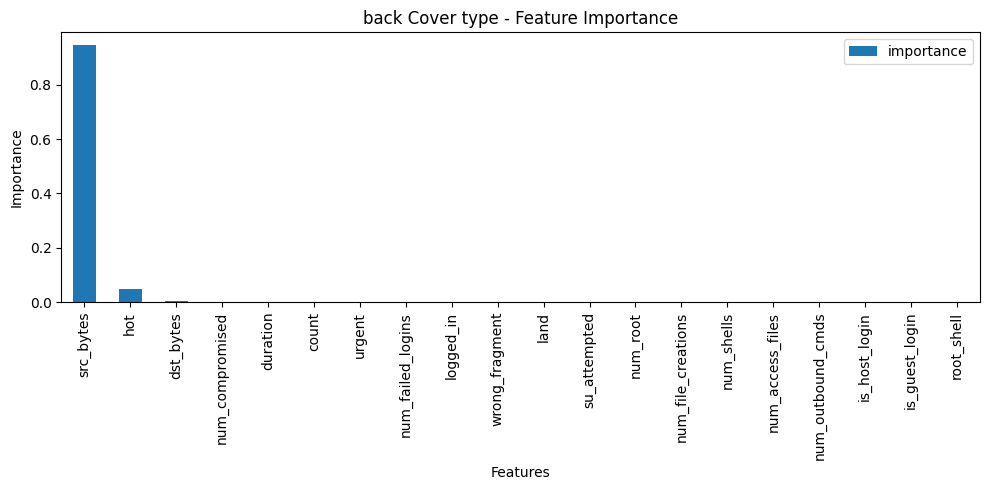

-----------------------------------------------------------------------------------------------




Processing CSV file: smurf.csv
smurf importance list:
smurf 
                     importance
Features                      
count                 0.001664
src_bytes             0.000046
wrong_fragment        0.000026
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
land                  0.000000
dst_bytes             0.000000
root_shell            0.000000 



smurf=["count","src_bytes","wrong_fragment","su_attempted","is_guest_login"]


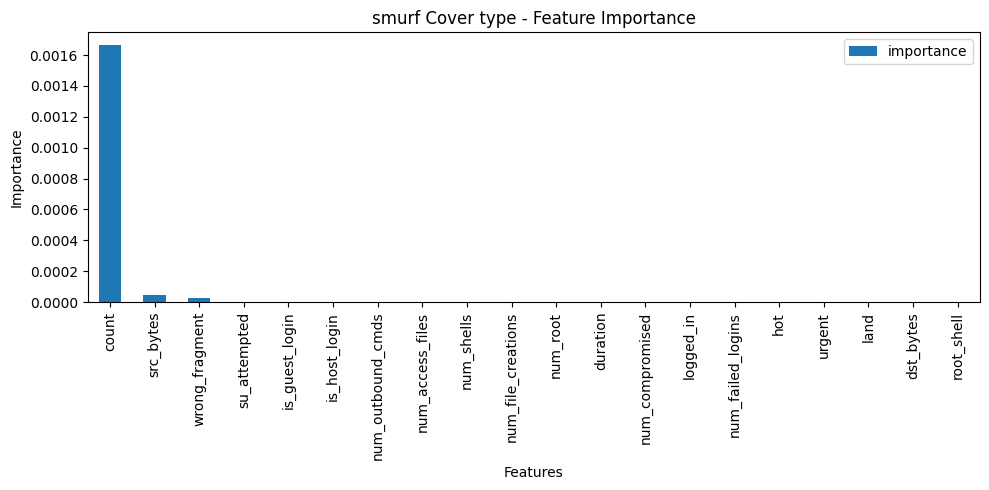

-----------------------------------------------------------------------------------------------




Processing CSV file: ipsweep.csv
ipsweep importance list:
ipsweep 
                     importance
Features                      
src_bytes             0.009220
count                 0.001384
dst_bytes             0.000068
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
root_shell            0.000000 



ipsweep=["src_bytes","count","dst_bytes","su_attempted","is_guest_login"]


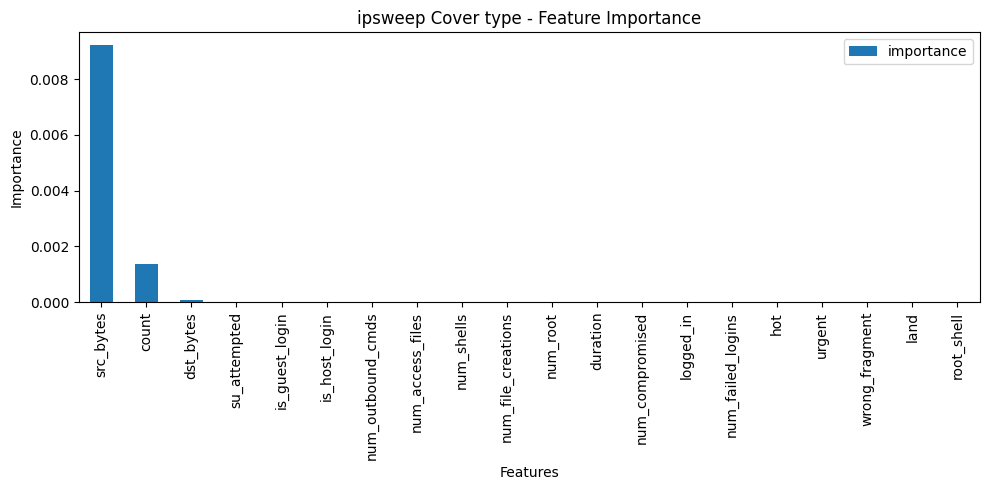

-----------------------------------------------------------------------------------------------




Processing CSV file: udpstorm.csv
udpstorm importance list:
udpstorm 
                     importance
Features                      
src_bytes             0.102326
duration              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



udpstorm=["src_bytes","duration","is_guest_login","is_host_login","num_outbound_cmds"]


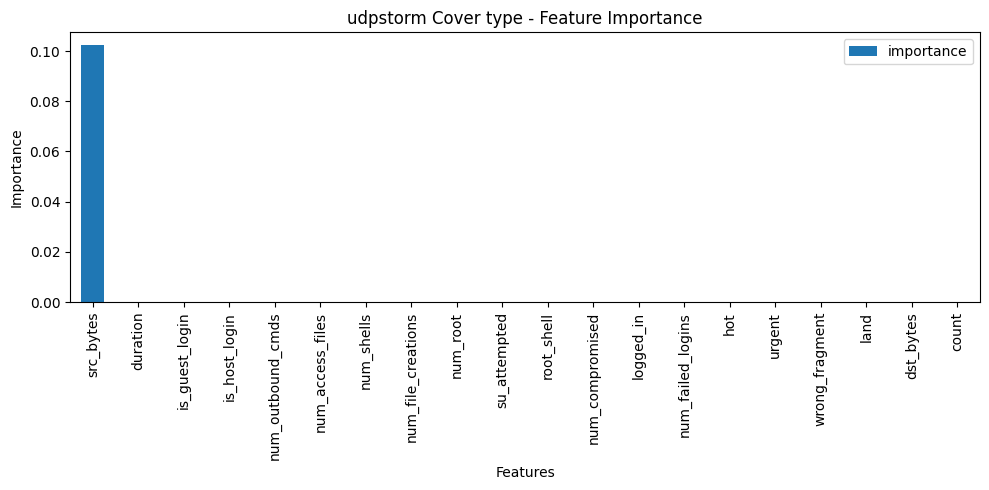

-----------------------------------------------------------------------------------------------




Processing CSV file: ps.csv
ps importance list:
ps 
                     importance
Features                      
duration              0.252956
src_bytes             0.050186
count                 0.028334
hot                   0.010150
dst_bytes             0.007827
num_compromised       0.000843
num_root              0.000636
num_file_creations    0.000323
num_shells            0.000273
land                  0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
su_attempted          0.000000
wrong_fragment        0.000000
logged_in             0.000000
num_failed_logins     0.000000
urgent                0.000000
root_shell            0.000000 



ps=["duration","src_bytes","count","hot","dst_bytes"]


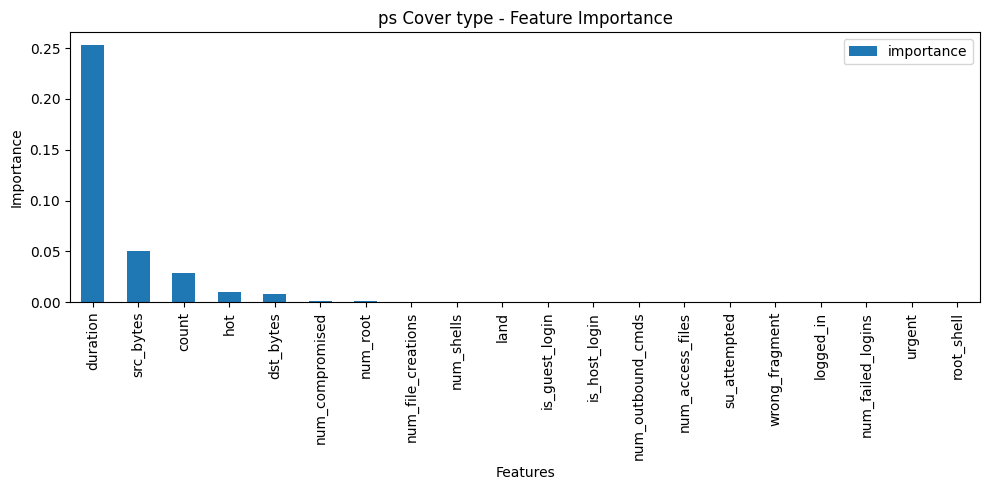

-----------------------------------------------------------------------------------------------




Processing CSV file: neptune.csv
neptune importance list:
neptune 
                     importance
Features                      
count                 0.004258
src_bytes             0.000145
logged_in             0.000085
dst_bytes             0.000052
duration              0.000005
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



neptune=["count","src_bytes","logged_in","dst_bytes","duration"]


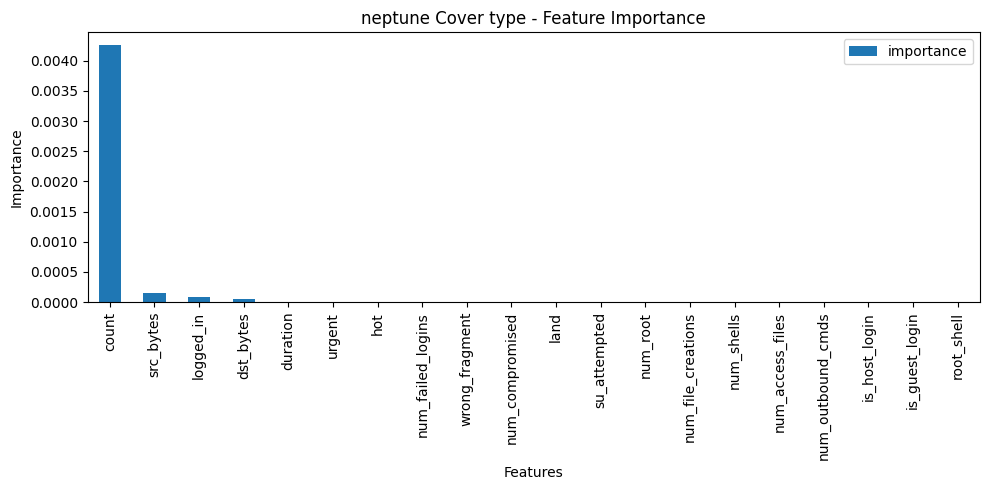

-----------------------------------------------------------------------------------------------




Processing CSV file: teardrop.csv
teardrop importance list:
teardrop 
                     importance
Features                      
wrong_fragment           0.976
src_bytes                0.008
duration                 0.000
su_attempted             0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
land                     0.000
dst_bytes                0.000
count                    0.000 



teardrop=["wrong_fragment","src_bytes","duration","su_attempted","is_guest_login"]


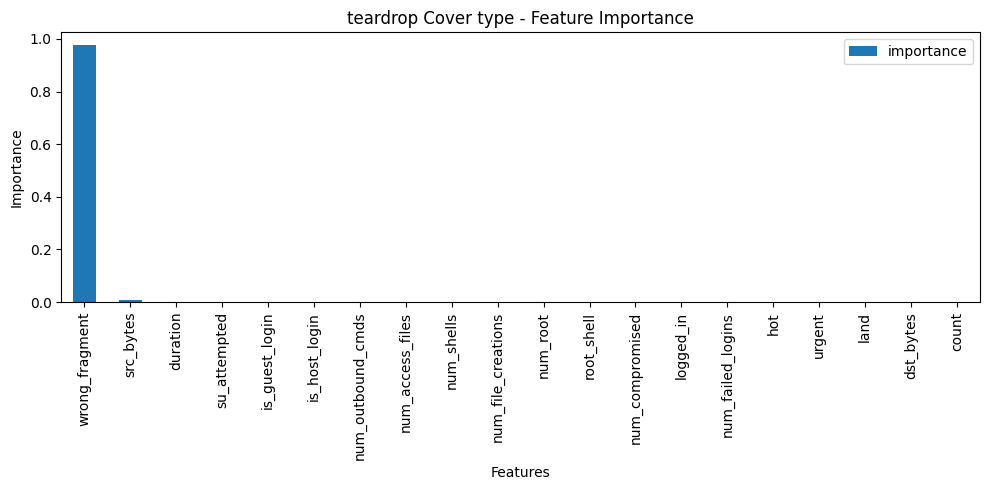

-----------------------------------------------------------------------------------------------




Processing CSV file: pod.csv
pod importance list:
pod 
                     importance
Features                      
duration                   0.0
src_bytes                  0.0
is_guest_login             0.0
is_host_login              0.0
num_outbound_cmds          0.0
num_access_files           0.0
num_shells                 0.0
num_file_creations         0.0
num_root                   0.0
su_attempted               0.0
root_shell                 0.0
num_compromised            0.0
logged_in                  0.0
num_failed_logins          0.0
hot                        0.0
urgent                     0.0
wrong_fragment             0.0
land                       0.0
dst_bytes                  0.0
count                      0.0 



pod=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


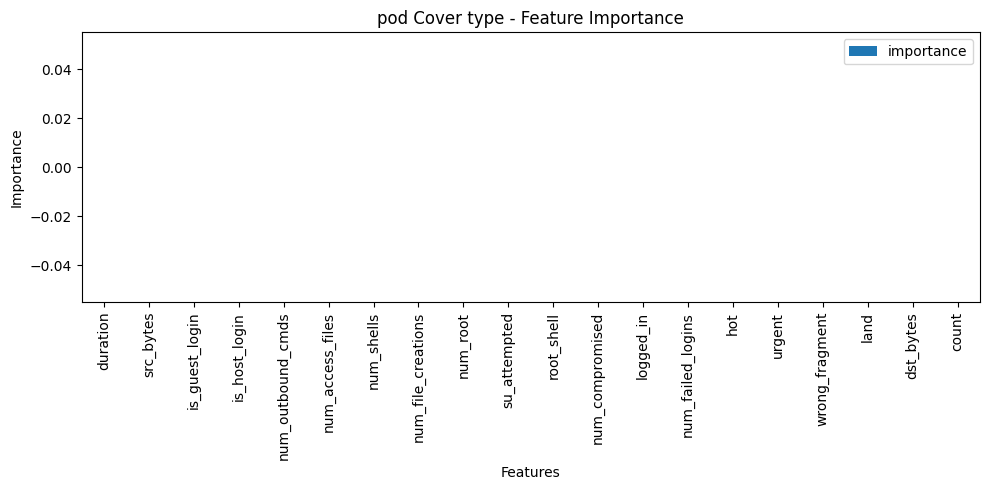

-----------------------------------------------------------------------------------------------




Processing CSV file: warezmaster.csv
warezmaster importance list:
warezmaster 
                     importance
Features                      
src_bytes             0.032996
dst_bytes             0.014529
duration              0.006696
is_guest_login        0.001389
hot                   0.000848
count                 0.000166
logged_in             0.000072
urgent                0.000000
num_failed_logins     0.000000
num_compromised       0.000000
wrong_fragment        0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
land                  0.000000
root_shell            0.000000 



warezmaster=["src_bytes","dst_bytes","duration","is_guest_login","hot"]


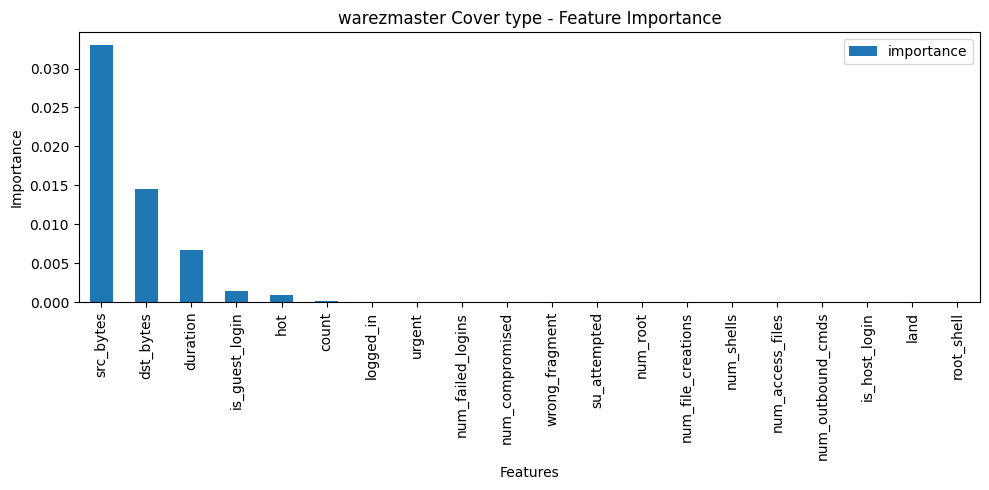

-----------------------------------------------------------------------------------------------




Processing CSV file: named.csv
named importance list:
named 
                     importance
Features                      
duration                   0.0
src_bytes                  0.0
is_guest_login             0.0
is_host_login              0.0
num_outbound_cmds          0.0
num_access_files           0.0
num_shells                 0.0
num_file_creations         0.0
num_root                   0.0
su_attempted               0.0
root_shell                 0.0
num_compromised            0.0
logged_in                  0.0
num_failed_logins          0.0
hot                        0.0
urgent                     0.0
wrong_fragment             0.0
land                       0.0
dst_bytes                  0.0
count                      0.0 



named=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


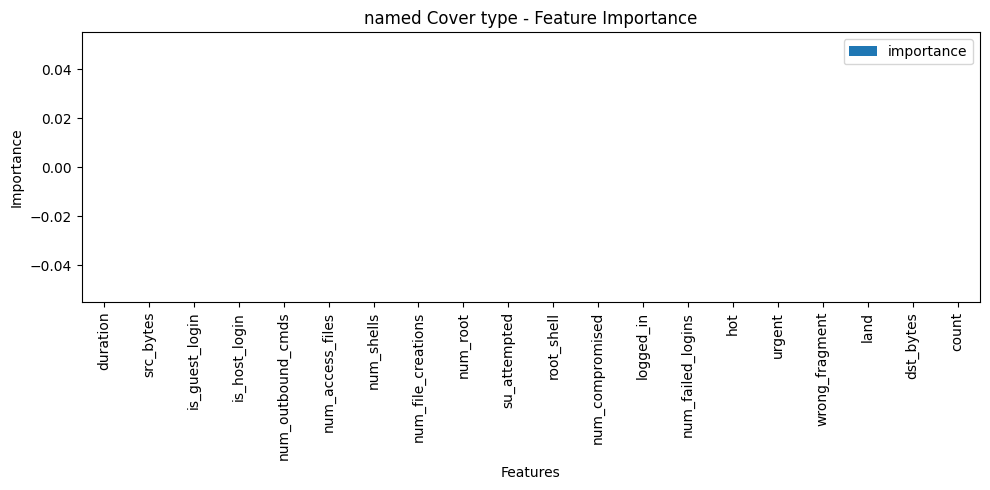

-----------------------------------------------------------------------------------------------




Processing CSV file: xterm.csv
xterm importance list:
xterm 
                     importance
Features                      
src_bytes             0.059622
hot                   0.029715
duration              0.024046
dst_bytes             0.002054
root_shell            0.001419
num_compromised       0.001273
urgent                0.001149
is_host_login         0.000343
num_root              0.000295
wrong_fragment        0.000000
num_failed_logins     0.000000
logged_in             0.000000
land                  0.000000
su_attempted          0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_guest_login        0.000000
count                 0.000000 



xterm=["src_bytes","hot","duration","dst_bytes","root_shell"]


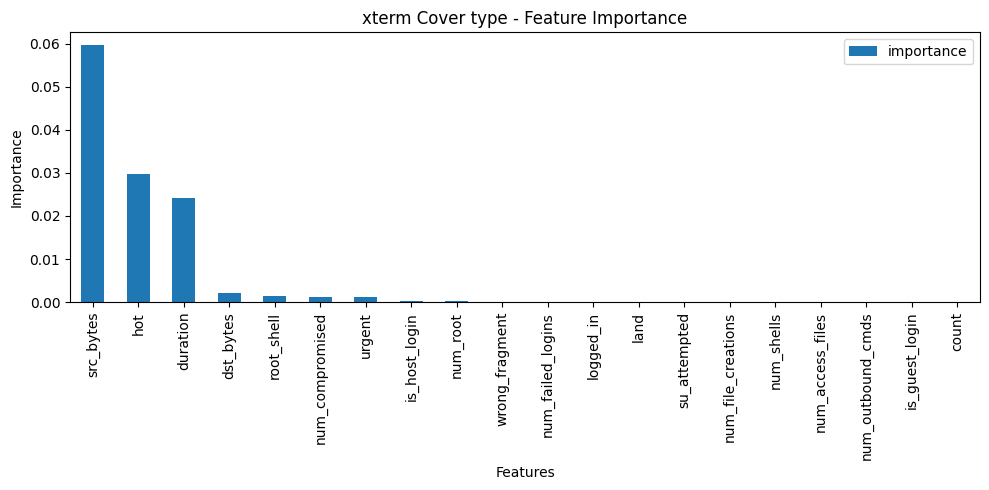

-----------------------------------------------------------------------------------------------




Processing CSV file: snmpguess.csv
snmpguess importance list:
snmpguess 
                     importance
Features                      
src_bytes             0.797756
count                 0.003989
dst_bytes             0.000814
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
root_shell            0.000000 



snmpguess=["src_bytes","count","dst_bytes","su_attempted","is_guest_login"]


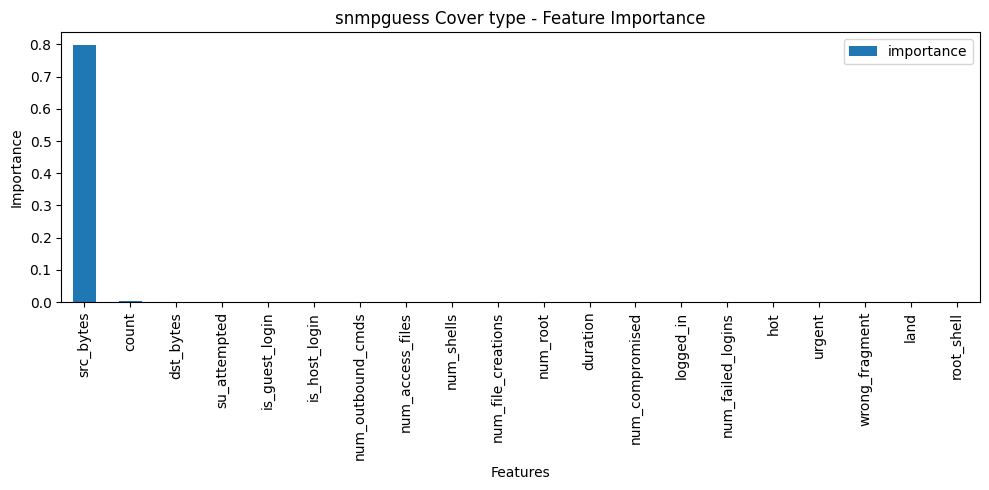

-----------------------------------------------------------------------------------------------




Processing CSV file: xsnoop.csv
xsnoop importance list:
xsnoop 
                     importance
Features                      
duration              0.206834
src_bytes             0.027970
is_host_login         0.027267
num_root              0.019015
root_shell            0.016194
dst_bytes             0.013959
hot                   0.013217
num_file_creations    0.008097
count                 0.002210
urgent                0.000000
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
wrong_fragment        0.000000
su_attempted          0.000000
land                  0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_guest_login        0.000000 



xsnoop=["duration","src_bytes","is_host_login","num_root","root_shell"]


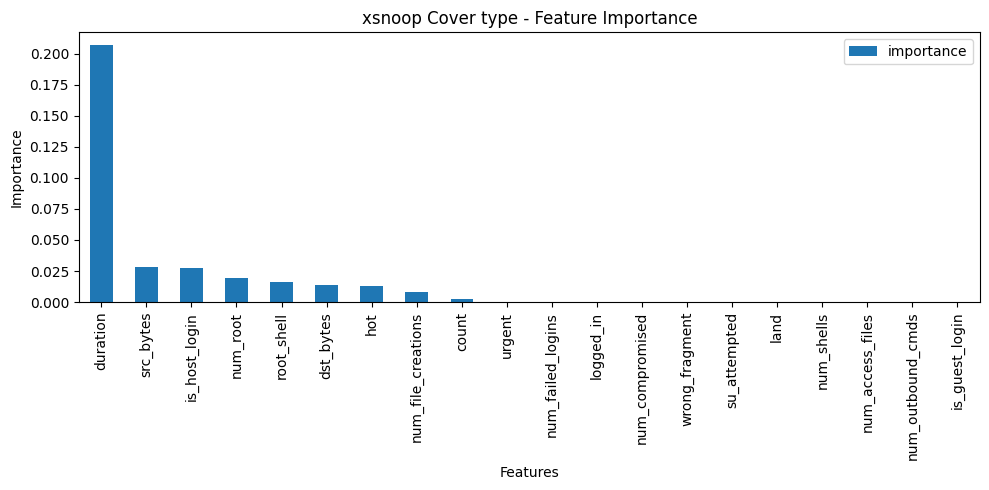

-----------------------------------------------------------------------------------------------




Processing CSV file: rootkit.csv
rootkit importance list:
rootkit 
                     importance
Features                      
count                 0.046078
hot                   0.032429
duration              0.028762
src_bytes             0.020575
is_host_login         0.001777
num_root              0.001123
num_file_creations    0.000676
root_shell            0.000600
num_compromised       0.000389
logged_in             0.000329
dst_bytes             0.000258
num_shells            0.000175
num_access_files      0.000000
is_guest_login        0.000000
num_outbound_cmds     0.000000
land                  0.000000
wrong_fragment        0.000000
num_failed_logins     0.000000
urgent                0.000000
su_attempted          0.000000 



rootkit=["count","hot","duration","src_bytes","is_host_login"]


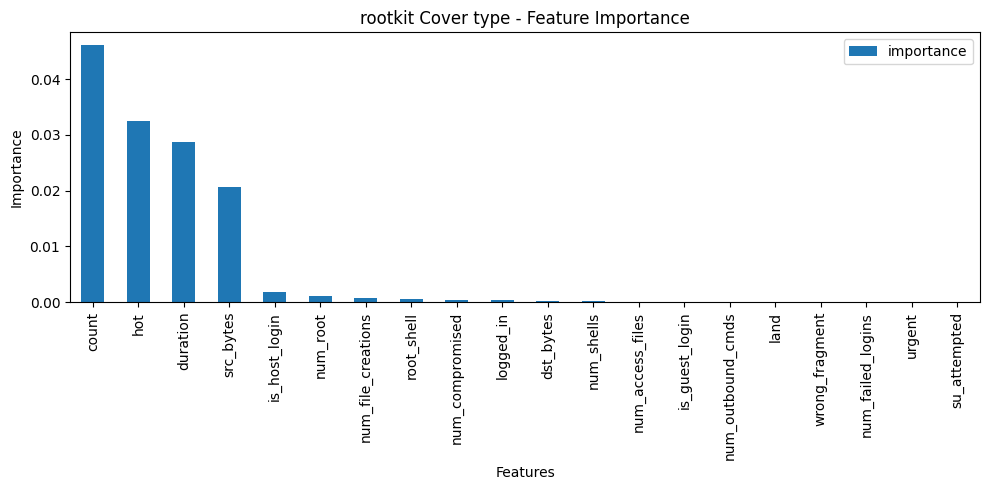

-----------------------------------------------------------------------------------------------




Processing CSV file: ftp_write.csv
ftp_write importance list:
ftp_write 
                     importance
Features                      
src_bytes             0.060484
duration              0.047256
urgent                0.041494
num_access_files      0.018712
num_file_creations    0.017437
is_guest_login        0.006861
hot                   0.004149
num_root              0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_shells            0.000000
root_shell            0.000000
su_attempted          0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



ftp_write=["src_bytes","duration","urgent","num_access_files","num_file_creations"]


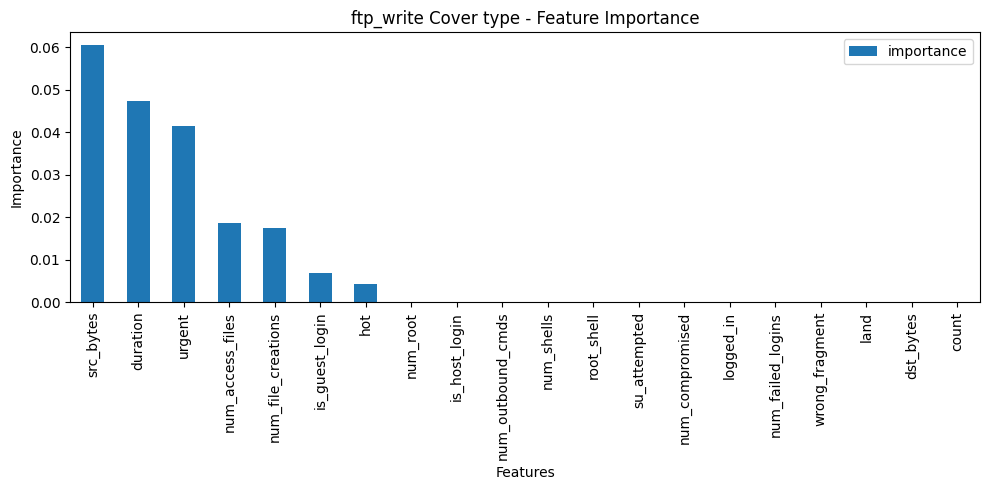

-----------------------------------------------------------------------------------------------




Processing CSV file: snmpgetattack.csv
snmpgetattack importance list:
snmpgetattack 
                     importance
Features                      
dst_bytes             0.198925
count                 0.011722
duration              0.000555
src_bytes             0.000039
hot                   0.000009
land                  0.000000
num_file_creations    0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
su_attempted          0.000000
num_root              0.000000
wrong_fragment        0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
urgent                0.000000
root_shell            0.000000 



snmpgetattack=["dst_bytes","count","duration","src_bytes","hot"]


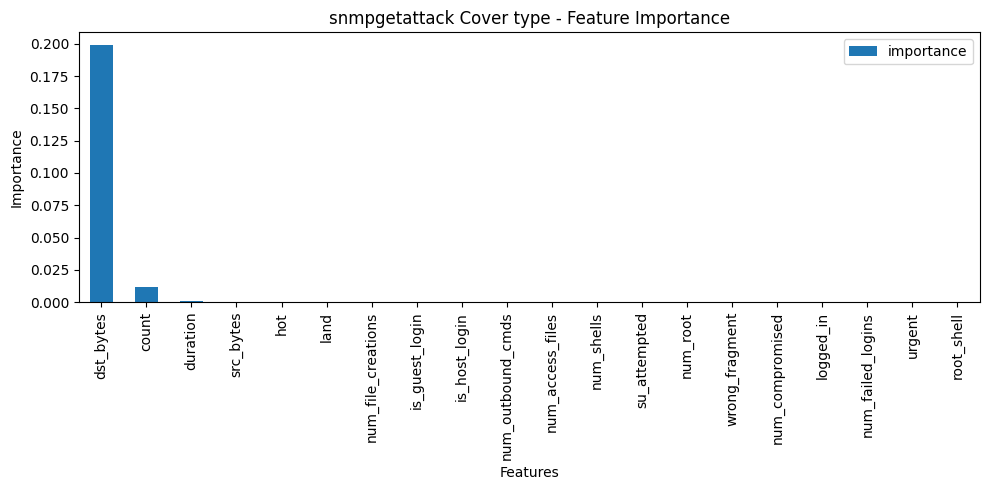

-----------------------------------------------------------------------------------------------




Processing CSV file: saint.csv
saint importance list:
saint 
                     importance
Features                      
src_bytes             0.938420
dst_bytes             0.030339
count                 0.001649
logged_in             0.000574
duration              0.000015
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



saint=["src_bytes","dst_bytes","count","logged_in","duration"]


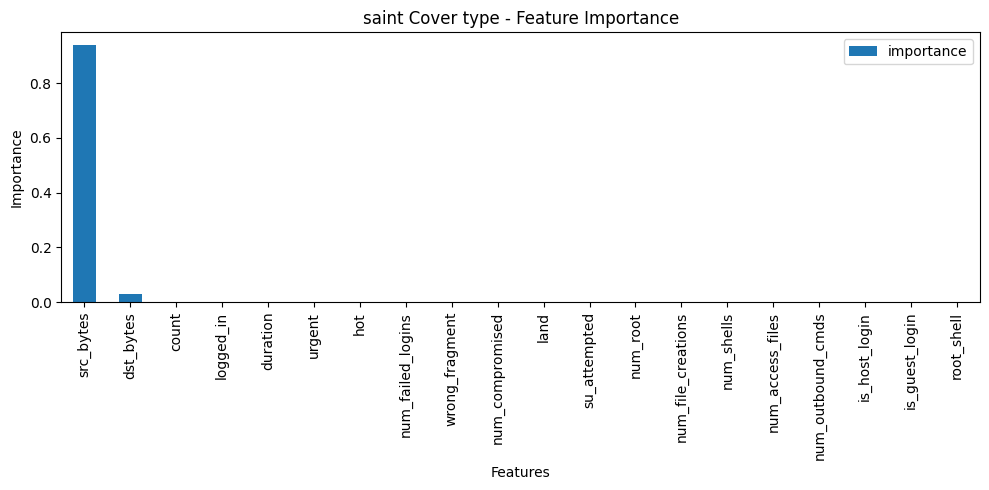

-----------------------------------------------------------------------------------------------




Processing CSV file: sqlattack.csv
sqlattack importance list:
sqlattack 
                     importance
Features                      
num_root              0.128440
num_access_files      0.128440
root_shell            0.110092
num_shells            0.100917
urgent                0.096330
num_file_creations    0.091743
duration              0.068807
hot                   0.041284
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
src_bytes             0.000000
su_attempted          0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



sqlattack=["num_root","num_access_files","root_shell","num_shells","urgent"]


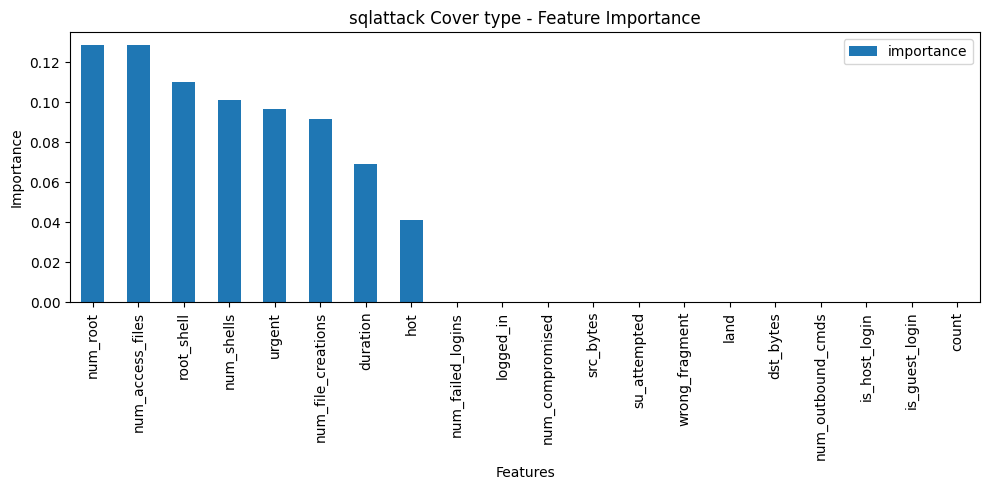

-----------------------------------------------------------------------------------------------




Processing CSV file: land.csv
land importance list:
land 
                     importance
Features                      
land                     0.164
src_bytes                0.060
duration                 0.000
su_attempted             0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
wrong_fragment           0.000
dst_bytes                0.000
count                    0.000 



land=["land","src_bytes","duration","su_attempted","is_guest_login"]


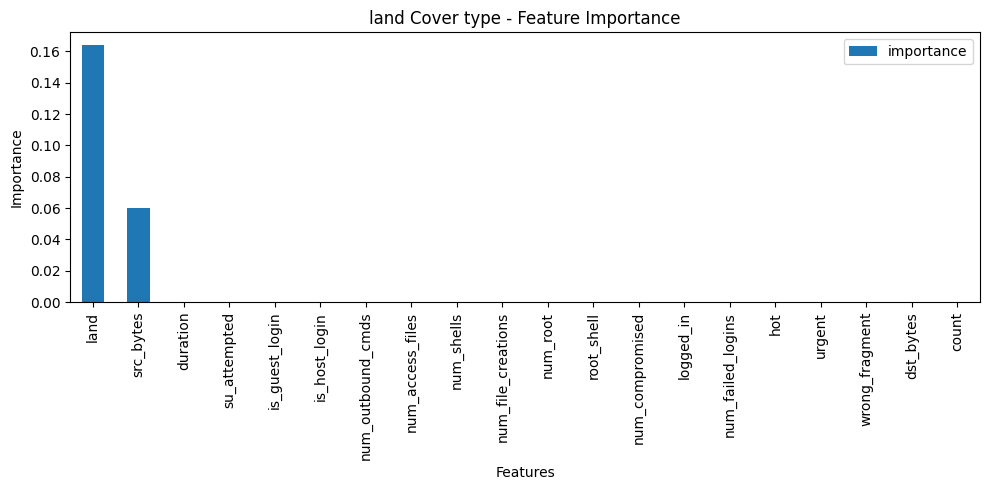

-----------------------------------------------------------------------------------------------




Processing CSV file: perl.csv
perl importance list:
perl 
                     importance
Features                      
num_shells            0.174312
num_file_creations    0.160550
duration              0.068807
root_shell            0.013761
num_root              0.009174
wrong_fragment        0.000000
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
src_bytes             0.000000
su_attempted          0.000000
land                  0.000000
dst_bytes             0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



perl=["num_shells","num_file_creations","duration","root_shell","num_root"]


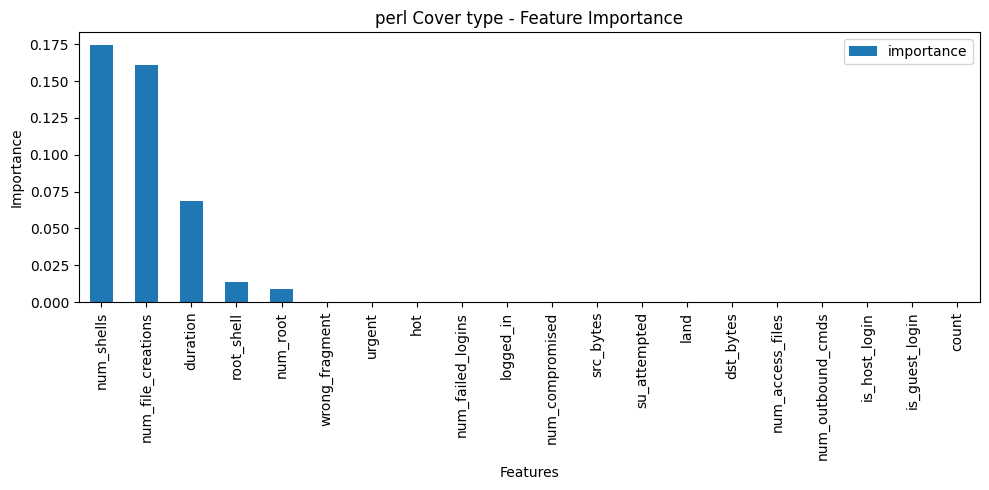

-----------------------------------------------------------------------------------------------




Processing CSV file: apache2.csv
apache2 importance list:
apache2 
                     importance
Features                      
src_bytes             0.001543
duration              0.000359
dst_bytes             0.000160
count                 0.000023
wrong_fragment        0.000000
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



apache2=["src_bytes","duration","dst_bytes","count","wrong_fragment"]


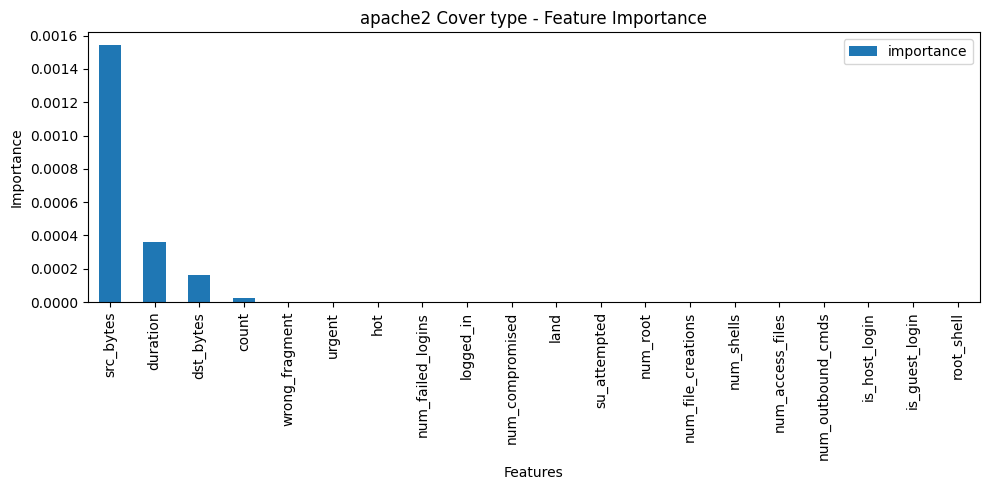

-----------------------------------------------------------------------------------------------




Processing CSV file: guess_passwd.csv
guess_passwd importance list:
guess_passwd 
                     importance
Features                      
num_failed_logins     0.223893
dst_bytes             0.000747
duration              0.000414
src_bytes             0.000283
logged_in             0.000052
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
root_shell            0.000000
su_attempted          0.000000
num_compromised       0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



guess_passwd=["num_failed_logins","dst_bytes","duration","src_bytes","logged_in"]


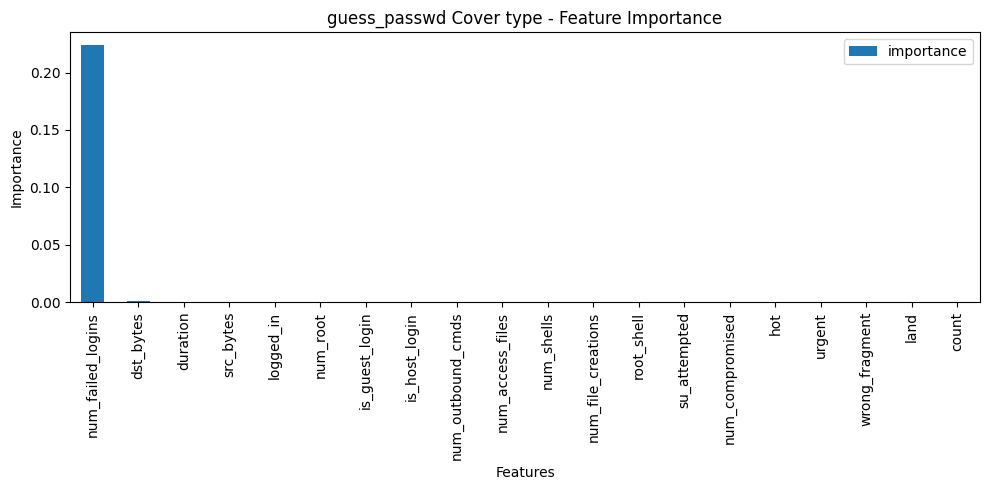

-----------------------------------------------------------------------------------------------




Processing CSV file: xlock.csv
xlock importance list:
xlock 
                     importance
Features                      
duration                 0.700
dst_bytes                0.008
su_attempted             0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
root_shell               0.000
src_bytes                0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
wrong_fragment           0.000
land                     0.000
count                    0.000 



xlock=["duration","dst_bytes","su_attempted","is_guest_login","is_host_login"]


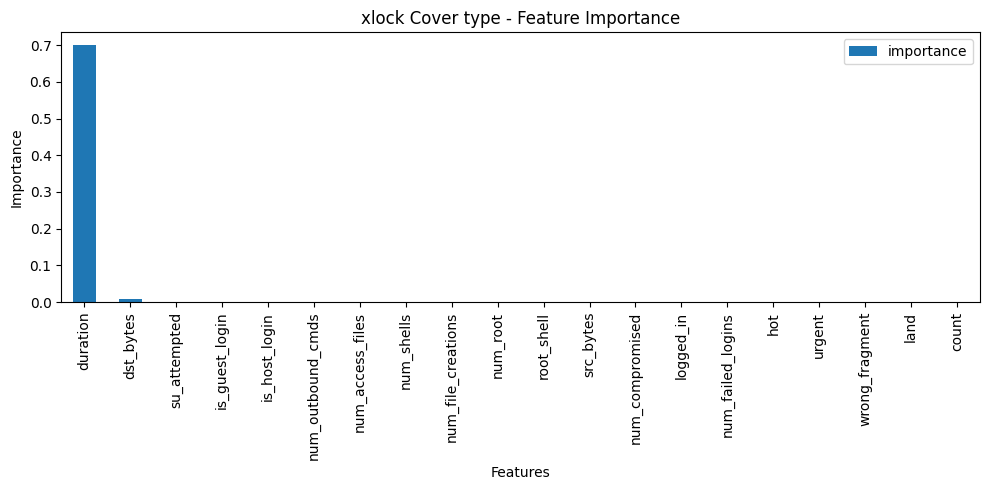

-----------------------------------------------------------------------------------------------




Processing CSV file: nmap.csv
nmap importance list:
nmap 
                     importance
Features                      
src_bytes                0.064
duration                 0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
su_attempted             0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
wrong_fragment           0.000
land                     0.000
dst_bytes                0.000
count                    0.000 



nmap=["src_bytes","duration","is_guest_login","is_host_login","num_outbound_cmds"]


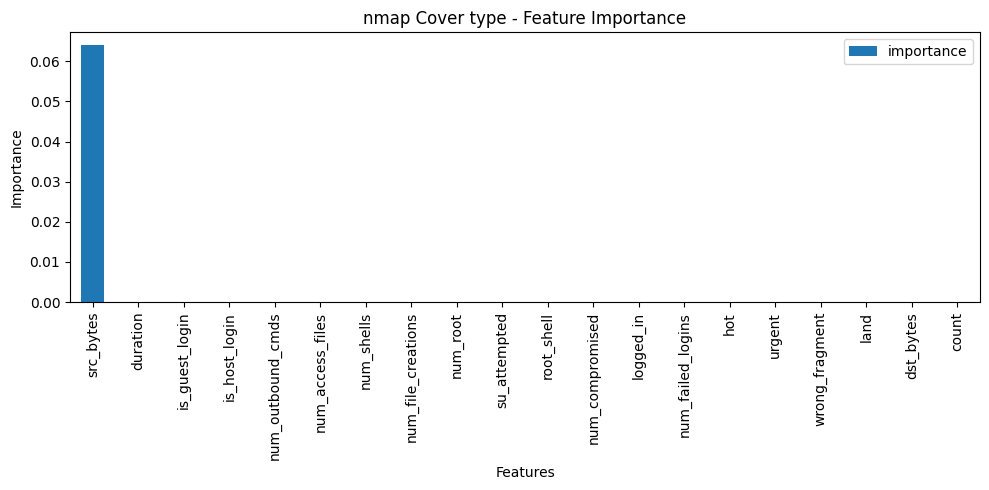

-----------------------------------------------------------------------------------------------




Processing CSV file: worm.csv
worm importance list:
worm 
                     importance
Features                      
duration              0.401914
src_bytes             0.081340
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



worm=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


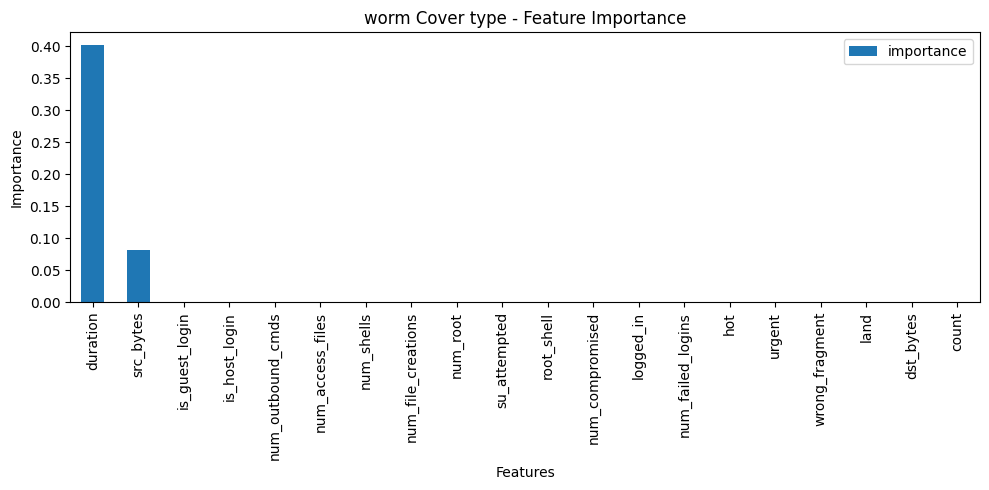

-----------------------------------------------------------------------------------------------




Processing CSV file: multihop.csv
multihop importance list:
multihop 
                     importance
Features                      
src_bytes             0.031022
duration              0.005877
count                 0.004080
is_host_login         0.003783
num_file_creations    0.001901
hot                   0.000932
logged_in             0.000353
dst_bytes             0.000300
land                  0.000000
is_guest_login        0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
su_attempted          0.000000
num_root              0.000000
wrong_fragment        0.000000
num_compromised       0.000000
num_failed_logins     0.000000
urgent                0.000000
root_shell            0.000000 



multihop=["src_bytes","duration","count","is_host_login","num_file_creations"]


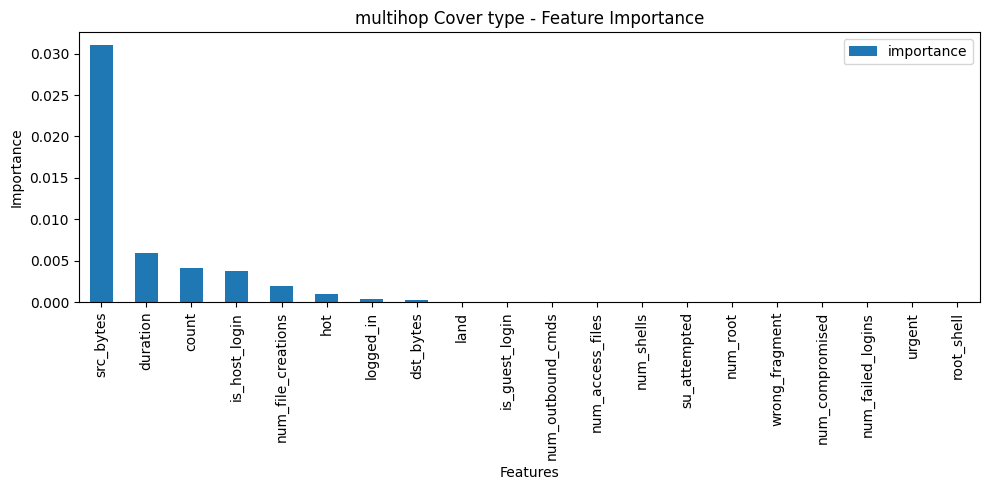

-----------------------------------------------------------------------------------------------




Processing CSV file: satan.csv
satan importance list:
satan 
                     importance
Features                      
src_bytes             0.000943
count                 0.000212
duration              0.000077
dst_bytes             0.000038
land                  0.000000
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
su_attempted          0.000000
wrong_fragment        0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
root_shell            0.000000 



satan=["src_bytes","count","duration","dst_bytes","land"]


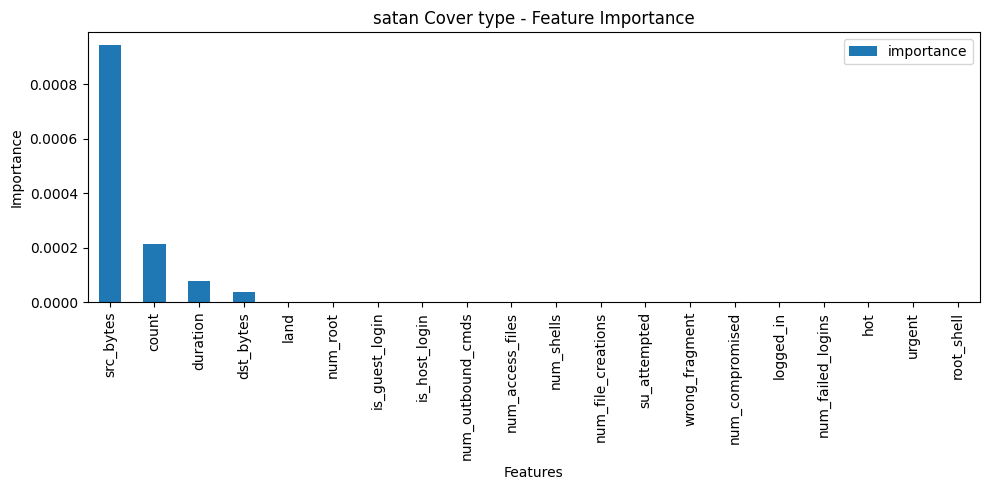

-----------------------------------------------------------------------------------------------




Processing CSV file: mailbomb.csv
mailbomb importance list:
mailbomb 
                     importance
Features                      
src_bytes             0.039843
duration              0.000776
dst_bytes             0.000050
logged_in             0.000002
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
root_shell            0.000000
su_attempted          0.000000
num_compromised       0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



mailbomb=["src_bytes","duration","dst_bytes","logged_in","num_root"]


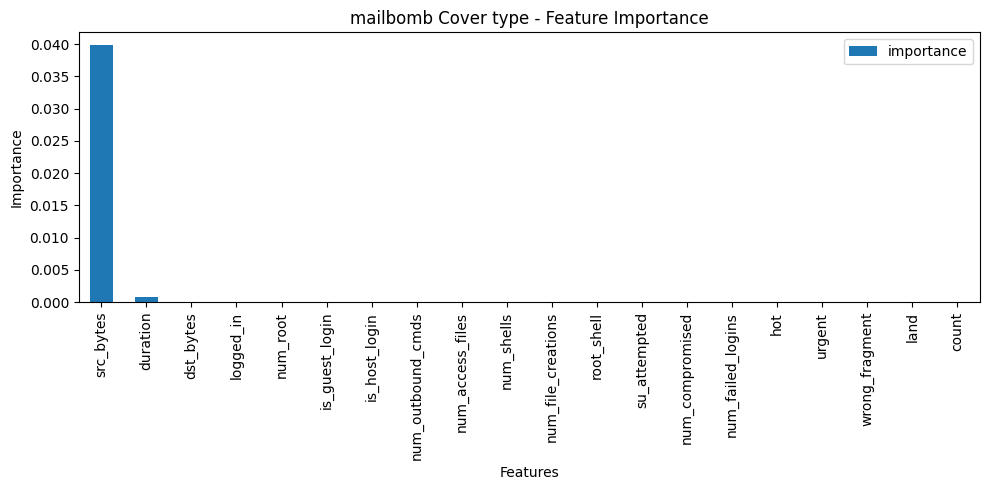

-----------------------------------------------------------------------------------------------




feature_importances: {'portsweep': ['src_bytes', 'duration', 'is_guest_login', 'is_host_login', 'num_outbound_cmds'], 'processtable': ['src_bytes', 'dst_bytes', 'logged_in', 'duration', 'num_root'], 'phf': ['hot', 'num_access_files', 'src_bytes', 'root_shell', 'dst_bytes'], 'loadmodule': ['duration', 'hot', 'num_compromised', 'root_shell', 'num_file_creations'], 'httptunnel': ['hot', 'src_bytes', 'duration', 'num_shells', 'num_root'], 'mscan': ['src_bytes', 'count', 'is_guest_login', 'is_host_login', 'num_outbound_cmds'], 'buffer_overflow': ['duration', 'num_compromised', 'src_bytes', 'dst_bytes', 'hot'], 'sendmail': ['duration', 'num_access_files', 'root_shell', 'num_root', 'src_bytes'], 'imap': ['duration', 'src_bytes', 'is_guest_login', 'is_host_login', 'num_outbound_cmds'], 'back': ['src_bytes', 'hot', 'dst_bytes', 'num_compromised', 'duration'], 'smurf': ['count', 'src_bytes', 'wron

In [21]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, svm, impor_bars in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [22]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [27 14 27 ... 27 27 14]
Total operation time: =  9.490447044372559 seconds


Multiclass Classification Evaluation


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

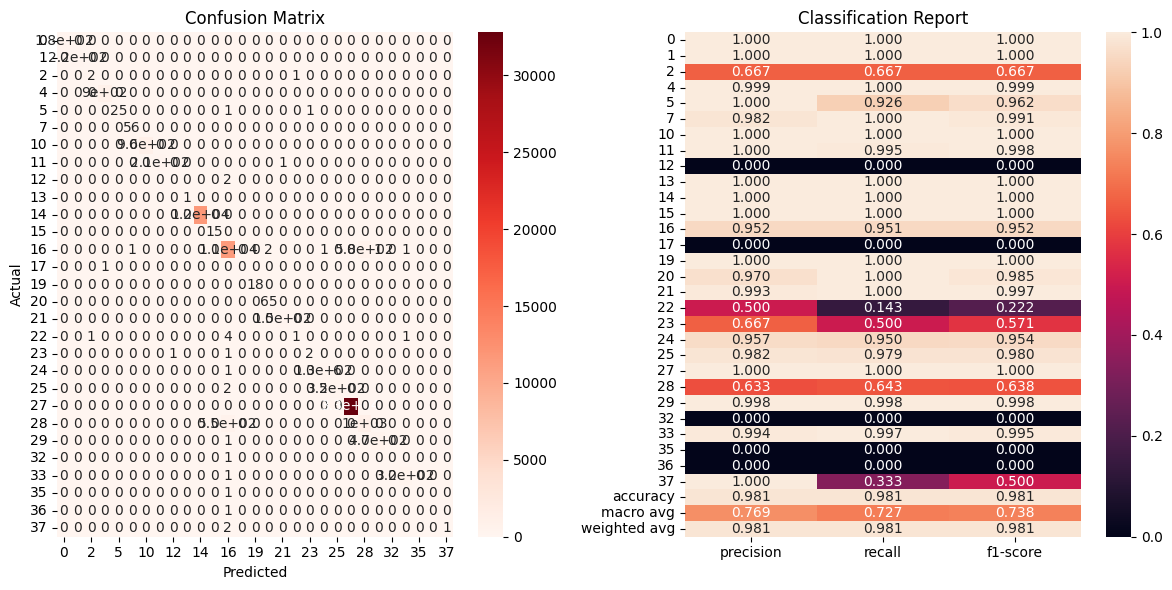

Accuracy: 0.9811272224544256


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.98113
f1-score_avg,0.98111
precision_avg,0.98113
recall_avg,0.98113


In [23]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [ ]:
knn_predictions = []
seconds = time.time()
THRESHOLD = 0.5
improve_cnt = 0
deprove_cnt = 0

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    
    if test_predictions[i] == NORMAL_TARGET:
        # class_probabilities = {}
        
        # # Test the normal data point with all anomaly models
        # for class_label, svm_model in SVMs.items():
        #     # Select features for the SVM
        #     selected_features = feature_importances[class_label]
        #     test_instance_selected_df = test_instance_df[selected_features]
        #     proba = svm_model.predict_proba(test_instance_selected_df)
            
        #     # We take the probability of class 0 (anomaly class)
        #     anomaly_proba = proba[0][0]
        #     class_probabilities[class_label] = anomaly_proba

        # # Get the class with the highest probability
        # most_probable_class = max(class_probabilities, key=class_probabilities.get)
        
        # # If the highest probability class has a probability greater than a threshold (e.g., 0.5), classify it as anomaly
        # if class_probabilities[most_probable_class] > 0.5:
        #     svm_predictions.append((0, INV_TARGET_DICT[most_probable_class], y_test_df.iloc[i]))
        # else:
        #     Otherwise, classify it as normal

        # New method
        knn_predictions.append((NORMAL_TARGET, y_test_df.iloc[i]))
        # Old method
        # knn_predictions.append((1, NORMAL_TARGET, y_test_df.iloc[i]))
    else:
        # New method
        predicted_label = TARGET_DICT[test_predictions[i]]
        abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if normal_class_prob < THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
                    if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                        max_prob = sub_abnormal_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            improve_cnt += 1
            status = 'improve'
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            deprove_cnt += 1
            status = 'deprove'
        print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, abnormal_class_prob, normal_class_prob)
        knn_predictions.append((final_class_2, y_test_df.iloc[i]))

        # Old method
        # predicted_label = TARGET_DICT[test_predictions[i]]
        # selected_features = feature_importances[predicted_label]
        # knn_model = KNNs[predicted_label]
        # test_instance_selected_df = test_instance_df[selected_features]
        # knn_prediction = knn_model.predict(test_instance_selected_df)
        # print(knn_prediction)
        # knn_predictions.append((knn_prediction[0], INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))
print('improve_cnt', improve_cnt, 'deprove_cnt', deprove_cnt)
print("Total operation time: = ", time.time() - seconds, "seconds")

final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 14 final_class2 14 actual 14  [1.] [0.]
final_class1 27 final_class2 27 actual 27  [1.

In [ ]:
# Evaluate KNN on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final")

# Modify the list and extract the second element in one step
final_knn_predictions = [t[0] for t in knn_predictions] # New
# final_knn_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in knn_predictions] # Old
final_knn_predictions_df = pd.DataFrame(final_knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()